In [1]:
from scipy.stats import iqr
from datetime import datetime
from copy import deepcopy
import math
from scipy.stats import pearsonr
from sklearn.externals.joblib import Parallel,delayed
import warnings
import pandas as pd
import pickle
import os
import numpy as np
warnings.filterwarnings('ignore')

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return average, math.sqrt(variance)

def get_rr_features(a):
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])

def get_weighted_rr_features(a):
    a = np.repeat(a[:,0],np.int64(np.round(100*a[:,1])))
    return np.array([np.var(a),iqr(a),np.mean(a),np.median(a),np.percentile(a,80),np.percentile(a,20),60000/np.median(a)])


def get_quality_features(a):
    features = [np.mean(a),np.median(a),len(a)/60]
    return np.array(features)

def get_daywise(data):
    return [a for i,a in data.groupby(['user','day']) if a.dropna().shape[0]>120]

def parse_day_data(data_day):
    data_day = data_day.sort_values('ltime').reset_index(drop=True)
    data_day['likelihood_max_array'] = data_day['likelihood_max_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['likelihood'] = data_day['likelihood_max_array'].apply(lambda a:np.max(a,axis=1))
    data_day['likelihood_ind'] = data_day['likelihood_max_array'].apply(lambda a:np.argmax(a,axis=1))
    data_day['rr_array'] = data_day['rr_array'].apply(lambda a:np.squeeze(a).reshape(-1,3))
    data_day['length'] = data_day['rr_array'].apply(lambda a:a.shape[0])
    data_day = data_day[data_day.length>40]
    data_day['time'] = data_day['ltime'].apply(lambda a:datetime.timestamp(a))
    indexes = data_day['likelihood_ind'].values
    rr_arrays = data_day['rr_array'].values
    rrs = []
    for i,rr in enumerate(rr_arrays):
        index = indexes[i]
        frr = np.squeeze(np.array([rr[i,index[i]] for i in range(rr.shape[0])]))
        rrs.append(frr)
    data_day['rr'] = rrs
    data_day['rr_col'] = data_day.apply(lambda a: np.vstack([np.squeeze(a['rr']),np.squeeze(a['likelihood']),np.squeeze(a['activity'])]).T,
                     axis=1)
    return data_day

def remove_3sd(heart_rate_window):
    temp = deepcopy(heart_rate_window)
    try:
        r,tt = weighted_avg_and_std(heart_rate_window[heart_rate_window[:,1]>.25,0],heart_rate_window[heart_rate_window[:,1]>.25,1])
        index = np.where((heart_rate_window[:,0]<r+3*tt)&(heart_rate_window[:,0]>r-3*tt))[0]
        heart_rate_window = heart_rate_window[index]
    except:
        pass
    if heart_rate_window.shape[0]>10:
        return [heart_rate_window,'Available']
    else:
        return [temp,'Not Available']

    
def parse_for_features(data_day):
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[np.where((a[:,1]>.05)&(a[:,0]>300)&(a[:,0]<1500)&(a[:,2]<.2))[0],:2])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:remove_3sd(a))
    data_day['length1'] = data_day['rr_col'].apply(lambda a:a[0].shape[0])
    data_day = data_day[data_day.length1>30]
    data_day['indicator'] = data_day['rr_col'].apply(lambda a:a[1])
    data_day['rr_col'] = data_day['rr_col'].apply(lambda a:a[0])
    data_day['likelihood'] = data_day['rr_col'].apply(lambda a:a[:,1])
    data_day['rr'] = data_day['rr_col'].apply(lambda a:a[:,0])
    data_day['rr_features'] = data_day['rr'].apply(lambda a:get_rr_features(a))
    data_day['rr_weighted_features'] = data_day['rr_col'].apply(lambda a:get_weighted_rr_features(a))
    data_day['quality_features'] = data_day['likelihood'].apply(lambda a:get_quality_features(a))
    data_day['quality_mag'] = data_day['quality_features'].apply(lambda a:np.sqrt(np.sum(np.square(a))/len(a)))
    return data_day

def normalize_daywise(feature_matrix,quals1):
    for i in range(feature_matrix.shape[1]):
        m,s = weighted_avg_and_std(feature_matrix[:,i], quals1)
        feature_matrix[:,i]  = (feature_matrix[:,i] - m)/s
    return feature_matrix


def get_stress(data_day):
    stress_model = pickle.load(open('../models/stress_model.p','rb'))
    feature_matrix = np.array(list(data_day['rr_features'].values))
    quals1 = np.array(list(data_day['quality_mag'].values))
    feature_matrix = normalize_daywise(feature_matrix,quals1)
    stress_likelihood = stress_model.predict_proba(feature_matrix)[:,1]
    data_day['stress_likelihood1'] = stress_likelihood
    
    stress_model = pickle.load(open('../models/stress_model.p','rb'))
    feature_matrix = np.array(list(data_day['rr_weighted_features'].values))
    quals1 = np.array(list(data_day['quality_mag'].values))
    feature_matrix = normalize_daywise(feature_matrix,[1]*len(quals1))
#     feature_matrix = normalize_daywise(feature_matrix,quals1)
    stress_likelihood = stress_model.predict_proba(feature_matrix)[:,1]
    data_day['stress_likelihood2'] = stress_likelihood
    return data_day

# def get_corr1(data_day1):
#     if data_day1.shape[0]<60:
#         return np.zeros((0,6))
#     data_day1['quality_mag_1'] = data_day1['quality_mag'].apply(lambda a:np.round(1000*a)//10)
#     tmp = data_day1[['quality_mag_1','stress_likelihood']].dropna()
#     data_day = data_day1.dropna()
#     if data_day.shape[0]<60:
#         return np.zeros((0,6))
#     all_corr = np.array([np.array([df['quality_mag_1'].values[0],
#                           pearsonr(df['stress_likelihood_ecg'].values,df['stress_likelihood'].values)[0],
#                           pearsonr(df['stress_likelihood_ecg'].values,df['stress_likelihood1'].values)[0],
#                           pearsonr(df['stress_likelihood'].values,df['stress_likelihood1'].values)[0],
#                           tmp[tmp.quality_mag_1.isin([df['quality_mag_1'].values[0]])].shape[0],
#                           data_day1['stress_likelihood_ecg'].dropna().shape[0]]) for i,df in data_day.groupby(['quality_mag_1']) if df.shape[0]>10])
#     return all_corr

def get_corr(data_day1):
    if data_day1.shape[0]<60:
        return np.zeros((0,7))
    data_day1['quality_mag_1'] = data_day1['quality_mag'].apply(lambda a:np.round(50*a)/50)
    all_corr = []
#     print(data_day1['quality_mag_1'].values)
    for q in np.unique(data_day1['quality_mag_1'].values):
        tmp = data_day1[data_day1.quality_mag_1>=q]
        tmp2 = tmp[['stress_likelihood_ecg','stress_likelihood','stress_likelihood1','stress_likelihood2']].dropna()
        if tmp2.shape[0]<20:
            continue
        feature = np.array([q,
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood1'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood2'].values)[0],
                   pearsonr(tmp2['stress_likelihood'].values,tmp2['stress_likelihood1'].values)[0],
                   tmp['stress_likelihood1'].dropna().shape[0],
                   data_day1['stress_likelihood_ecg'].dropna().shape[0]])
        all_corr.append(feature)
    return np.array(all_corr)

def parse_each_day(a):
    ecg_len = a['stress_likelihood_ecg'].dropna().shape[0]
    a = parse_day_data(a)
    a = parse_for_features(a)
    a = get_stress(a)
    columns = ['window', 'ltime', 'likelihood_max_array', 'activity', 'rr_array',
               'time', 'timestamp', 'likelihood_mean', 'localtime',
               'stress_likelihood', 'stress_likelihood_ecg', 'ecg_rr_array', 'day',
               'version', 'user', 'quality_features', 'activity_features',
               'likelihood', 'likelihood_ind', 'length', 'rr', 'rr_col', 'length1',
               'indicator', 'rr_features', 'rr_weighted_features', 'quality_mag',
               'stress_likelihood1', 'stress_likelihood2']
    ppg_len = a['stress_likelihood1'].dropna().shape[0]
    all_corr = get_corr(a)
    tmp2 = a.dropna()
    tmp = np.array([pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood1'].values)[0],
                   pearsonr(tmp2['stress_likelihood_ecg'].values,tmp2['stress_likelihood2'].values)[0]])
    if len(tmp[~np.isnan(tmp)])<3:
        return np.zeros((0,7)),np.zeros((0,2)),np.zeros((0,3)),pd.DataFrame([],columns=columns)
    else:
        return all_corr,np.array([ecg_len,ppg_len]).reshape(-1,2),tmp.reshape(-1,3),a

def parse_each_participant(directory,d):
    data = pickle.load(open(directory+d,'rb'))
    data_all = get_daywise(data)
    if len(data_all)==0:
        return np.zeros((0,7)),np.zeros((0,2)),np.zeros((0,3))
    final_output = [parse_each_day(a) for a in data_all]
    final_qual_corr = np.concatenate([a[0] for a in final_output])
    final_yield = np.concatenate([a[1] for a in final_output])
    final_day_corr = np.concatenate([a[2] for a in final_output])
    user_df = pd.concat([a[3] for a in final_output])
    pickle.dump(user_df,open(directory1+d,'wb'))
    return final_qual_corr,final_yield,final_day_corr

directory = '../../cc3/rice_data/ecg_ppg_25_left/'
directory1 = '../../cc3/rice_data/ecg_ppg_25_left1/'
all_data = Parallel(n_jobs=30,verbose=2)(delayed(parse_each_participant)(directory,d) for d in os.listdir(directory) if d[-1]=='p')
# all_data = [parse_each_participant(directory,d) for d in os.listdir(directory) if d[-1]=='p']

C:\Users\mullah\AppData\Local\Continuum\miniconda3\envs\rr\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\mullah\AppData\Local\Continuum\miniconda3\envs\rr\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\mullah\AppData\Local\Continuum\miniconda3\envs\rr\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\mullah\AppData\Local\Continuum\miniconda3\envs\rr\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from job

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../cc3/rice_data/ecg_ppg_25_left/'

In [ ]:
data = np.concatenate([a[0] for a in all_data])
yld = np.concatenate([a[1] for a in all_data])
day_corr = np.concatenate([a[2] for a in all_data])

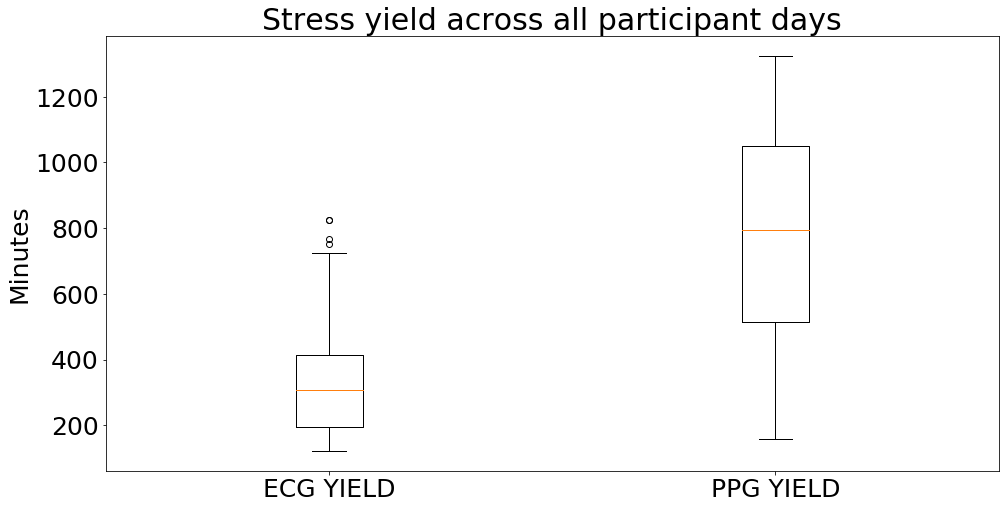

In [25]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})
plt.figure(figsize=(16,8))
plt.boxplot(yld)
plt.ylabel('Minutes')
plt.xticks(range(1,yld.shape[1]+1),['ECG YIELD','PPG YIELD'])
plt.title('Stress yield across all participant days')
plt.show()

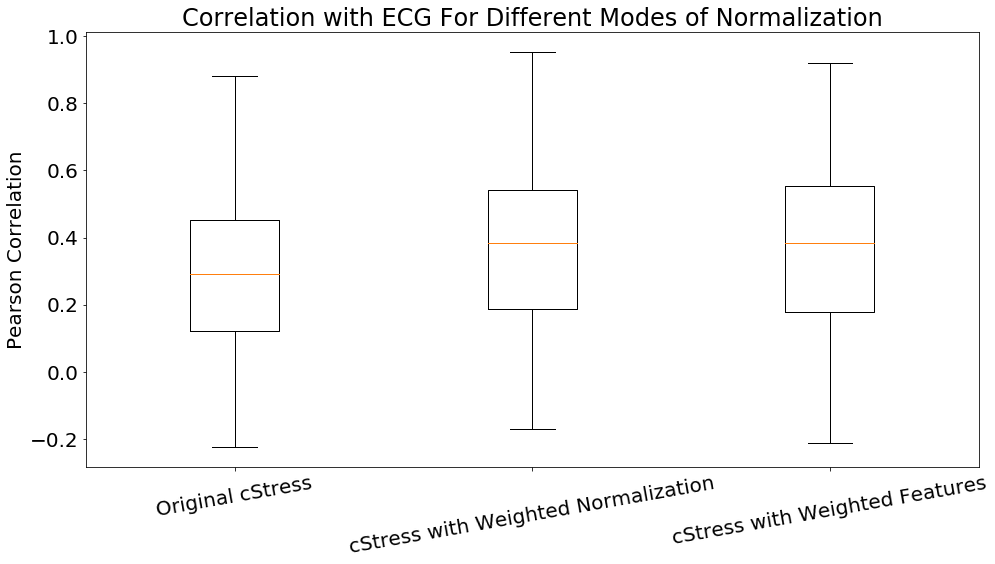

In [26]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,8))
plt.boxplot(day_corr)
plt.ylabel('Pearson Correlation')
plt.xticks(range(1,day_corr.shape[1]+1),['Original cStress','cStress with Weighted Normalization','cStress with Weighted Features'],rotation=10)
plt.title('Correlation with ECG For Different Modes of Normalization')
plt.show()

In [27]:
data_all = pd.DataFrame(data,columns=['quality','corr_orig','corr_new','corr_new1','corr_between','ppg_yield','ecg_yield'])

In [28]:
corr_25 = data_all.groupby('quality').quantile(.5)
# corr_75 = data_all.groupby('quality').quantile(.75)
x = corr_25.index.values

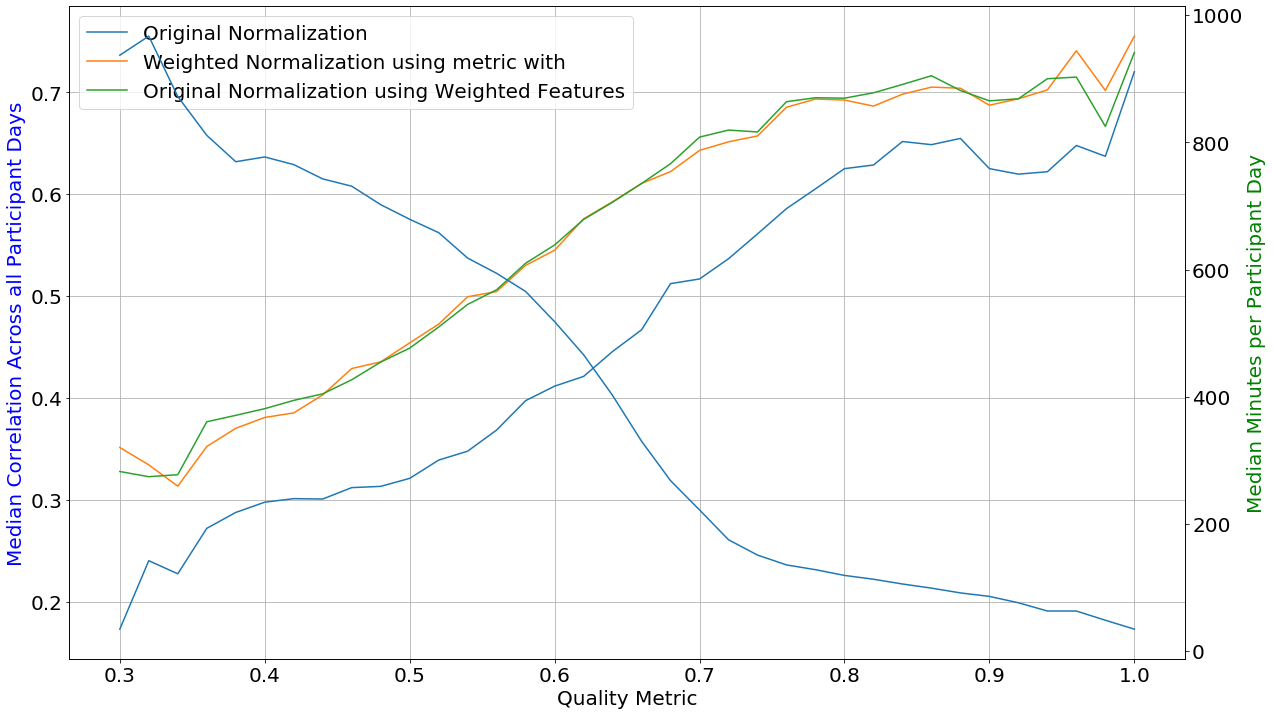

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':20})
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
ax1.plot(x,corr_25['corr_orig'].loc[x],label='Original Normalization')
ax1.plot(x,corr_25['corr_new'].loc[x],label='Weighted Normalization using metric with')
ax1.plot(x,corr_25['corr_new1'].loc[x],label='Original Normalization using Weighted Features')
ax2.plot(x,corr_25['ppg_yield'].loc[x],label='PPG Yield')
ax1.grid()
# ax1.plot(x,corr_75['corr_orig'].loc[x],label='Original 75th')
# ax1.plot(x,corr_75['corr_new'].loc[x],label='Weighted 75th')
ax1.legend(fontsize=20)
ax1.set_xlabel('Quality Metric')
ax2.set_ylabel('Median Minutes per Participant Day', color='g')
ax1.set_ylabel('Median Correlation Across all Participant Days', color='b')
plt.show()


# plt.figure(figsize=(16,8))



(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]),
 <a list of 48 Text xticklabel objects>)

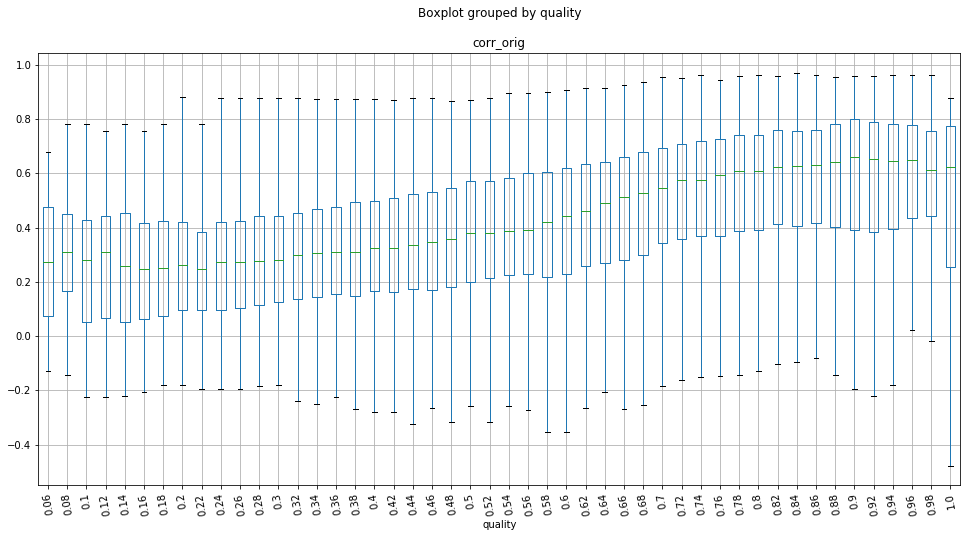

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('')
c = data_all.boxplot(column=['corr_orig'], by='quality', ax=ax,showfliers=False)
plt.xticks(rotation=100)

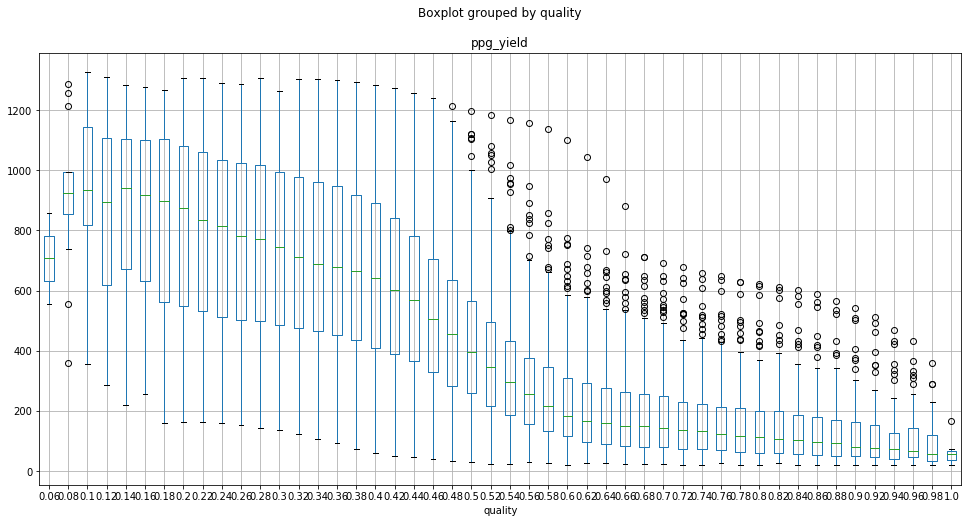

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))
plt.suptitle('')
c = data_all.boxplot(column=['ppg_yield'], by='quality', ax=ax)

In [ ]:
data_all.groupby('quality').quantile([.25,.75]).loc[(0.2, 0.25)]